# Preparation

In this example, we prepare training/validation data for melody/vocal separation task.

Before running bunch of codes below, please download `DSD100` dataset from
[the DSD100 download page](https://sigsep.github.io/datasets/dsd100.html)
and say it `DSD100.zip`.

### Initializing `AudioMixer`

In [1]:
%%capture
from chimeranet.audio_mixer import AudioMixer
from chimeranet.dataset_loader.dsd100\
    import DSD100MelodyLoader, DSD100VocalLoader

am = AudioMixer()
am.add_loader(
    DSD100MelodyLoader('DSD100.zip'),
    a_time = (-1, 1), # data augmentation on time axis
    a_freq = (-1, 1),  # data augmentation on frequency axis
    a_amp = (-5, 5), # data augmentation on signal power
).add_loader(
    DSD100VocalLoader('DSD100.zip'),
    a_time = (-1, 1),
    a_freq = (-1, 1),
    a_amp = (-5, 5),
)

### Mix audio and make training data

In [2]:
%%capture
from chimeranet.preprocessing import to_mixture, to_true_pair

time, sr = 0.75, 16000
n_fft, hop_length, n_mels = 512, 128, 96
am.time(time).sr(sr).n_fft(n_fft).hop_length(hop_length).n_mels(n_mels)

sample_size = 8
specs_train = am.make_specs(sample_size, n_jobs=4) # mix on 4 processes
x_train = to_mixture(specs_train)
y_train = to_true_pair(specs_train)

### Showing one of the training data

(8, 93, 96)
(8, 93, 96, 2) (8, 93, 96, 3)


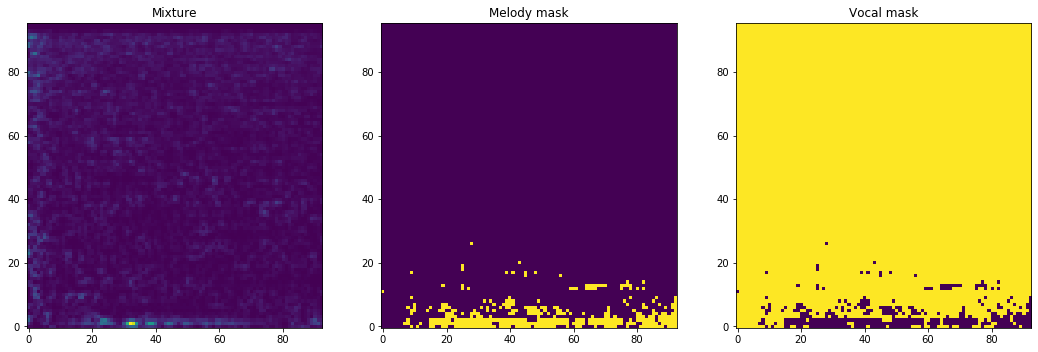

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

# sample_size x time_frames x n_mels
print(x_train.shape)
# sample_size x time_frames x n_mels x n_channels (n_channels+1)
print(y_train['embedding'].shape, y_train['mask'].shape)

idx = 7
mask_x = x_train[idx].transpose((1, 0))
mask_y1, mask_y2 = y_train['embedding'][idx].transpose((2, 1, 0))

fig = plt.figure(figsize=(18, 6))
ax1 = fig.add_subplot(131)
ax1.title.set_text('Mixture')
ax1.imshow(mask_x, origin='lower')
ax2 = fig.add_subplot(132)
ax2.title.set_text('Melody mask')
ax2.imshow(mask_y1, origin='lower', vmin=0, vmax=1)
ax3 = fig.add_subplot(133)
ax3.title.set_text('Vocal mask')
ax3.imshow(mask_y2, origin='lower', vmin=0, vmax=1)

### Validation data

Like training data, validation data can be made in almost same way.

In [4]:
%%capture
am_val = AudioMixer()
am_val.add_loader(
    DSD100MelodyLoader('DSD100.zip', test=True)
).add_loader(
    DSD100VocalLoader('DSD100.zip', test=True)
)
am_val.time(time).n_mels(n_mels).sr(sr).n_fft(n_fft).hop_length(hop_length)

specs_validation = am_val.make_specs(sample_size, n_jobs=4)
x_validation = to_mixture(specs_validation)
y_validation = to_true_pair(specs_validation)

### Saving

In [5]:
import h5py

with h5py.File('example-dataset.h5', 'w') as f:
    f.create_dataset('x_train', data=x_train)
    f.create_dataset('y_train_embedding', data=y_train['embedding'])
    f.create_dataset('y_train_mask', data=y_train['mask'])
    f.create_dataset('x_validation', data=x_validation)
    f.create_dataset('y_validation_embedding', data=y_validation['embedding'])
    f.create_dataset('y_validation_mask', data=y_validation['mask'])

[1] A. Liutkus et al., “The 2016 Signal Separation Evaluation Campaign,” in Latent Variable Analysis and Signal Separation - 12th International Conference, {LVA/ICA} 2015, Liberec, Czech Republic, August 25-28, 2015, Proceedings, 2017, pp. 323–332.